<a href="https://colab.research.google.com/github/Staiana/6123_Finance/blob/main/6123_G3_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and cleaning

In [24]:
# Import libraries that are useful for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


!pip install pulp

from pulp import LpProblem, LpVariable, LpMaximize, lpSum, LpBinary, PULP_CBC_CMD


In [25]:
url = "https://raw.githubusercontent.com/Staiana/6123_Finance/refs/heads/main/Loan_Portfolio_raw.csv"

# Load the dataset into a DataFrame (keeping all columns, knowing that headers are on row 2)
df = pd.read_csv(url, header=1)


#Cut the df to have only the data we are interested in

df = df.iloc[:200]  # Keep only the first 200 rows (corresponding to Loan Numbers 1 to 200, making sure that we don't have NaN later)
start_col = df.columns.get_loc("Loan Number")
# Retain only the columns starting from "Loan Number" (Delete the first few, Portfolio 1...)
df = df.iloc[:, start_col:]

display(df.head())
print(df.info())

,Loan Number,Loan Amount (USD),Industry,Lending Region,Country,Loan Additionality,Climate Change Hotspot,Biodiversity Hotspot,Soil Degradation Hotspot,Water Scarcity Hotspot,...,Farmers & Employees,Female \nFarmers & Employees,Probability of Default,Expected Revenue,Expected Operating Expenses,Expected Cost of Debt,Expected Cost of Risk,Expected Net Loan Income,Unnamed: 29,Unnamed: 30
0,46.0,717’500,Coffee,Central America,Honduras,Low,Yes,Yes,Yes,No,...,1’555,354,3.20%,90’952,-16’267,-18’618,-28’019,28’047,NaN,h
1,177.0,820’000,Coffee,East Africa,"Tanzania, United Republic Of",Medium,No,No,No,No,...,5’003,2’501,1.52%,72’841,-19’215,-20’556,-6’147,26’923,NaN,NaN
2,126.0,738’000,Coffee,Central America,Guatemala,Medium,No,Yes,No,No,...,1’106,221,1.61%,61’674,-11’847,-16’000,-12’870,20’957,NaN,NaN
3,171.0,738’000,Coffee,East Africa,"Congo, The Democratic Republic Of The",Medium,No,Yes,No,No,...,6’033,1’373,3.22%,89’537,-31’063,-19’400,-21’044,18’030,NaN,NaN
4,113.0,410’000,Coffee,Central America,Nicaragua,Low,Yes,Yes,No,No,...,244,31,1.99%,47’394,-13’320,-9’528,-9’729,14’817,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 26 columns):
 #   Column                                                                         Non-Null Count  Dtype  
---  ------                                                                         --------------  -----  
 0   Loan Number                                                                    200 non-null    float64
 1   Loan Amount (USD)                                                              200 non-null    object 
 2   Industry                                                                       200 non-null    object 
 3   Lending Region                                                                 200 non-null    object 
 4   Country                                                                        200 non-null    object 
 5   Loan Additionality                                                             200 non-null    object 
 6   Climate Change Hotspot    

In [26]:
df.columns

Index(['Loan Number', 'Loan Amount (USD)', 'Industry', 'Lending Region',
       'Country', 'Loan Additionality ', 'Climate Change Hotspot',
       'Biodiversity Hotspot', 'Soil Degradation Hotspot',
       'Water Scarcity Hotspot', 'Certification',
       'Planting & maintaining trees for biodiversity conservation and carbon capture',
       'Clean & appropriate tech for reduced emissions and resource efficiency',
       'Poverty Level', 'Gender Inclusion', 'Livelihood Improvement',
       'Farmers & Employees', 'Female \nFarmers & Employees',
       'Probability of Default', 'Expected Revenue',
       'Expected Operating Expenses', 'Expected Cost of Debt',
       'Expected Cost of Risk', 'Expected Net Loan Income', 'Unnamed: 29',
       'Unnamed: 30'],
      dtype='object')

In [27]:
df.dtypes

,0
Loan Number,float64
Loan Amount (USD),object
Industry,object
Lending Region,object
Country,object
Loan Additionality,object
Climate Change Hotspot,object
Biodiversity Hotspot,object
Soil Degradation Hotspot,object
Water Scarcity Hotspot,object


In [28]:
df["Loan Amount (USD)"] = pd.to_numeric(
    df["Loan Amount (USD)"].astype(str).str.replace("’", ''),
    errors='coerce'
)


# Convert to a NumPy array
loan_amounts = df["Loan Amount (USD)"].to_numpy()

print(loan_amounts[0:10])

[717500 820000 738000 738000 410000 615000 606800 820000 410000 410000]


In [29]:
# Do the same for the other columns that are numbers in the sheet

columns_to_convert = [
    "Farmers & Employees",
    "Female \nFarmers & Employees",
    "Probability of Default",
    "Expected Revenue",
    "Expected Operating Expenses",
    "Expected Cost of Debt",
    "Expected Cost of Risk",
    "Expected Net Loan Income"
]


# Loop through the list and convert each column to numeric (float)
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace("’", ''), errors='coerce')

# Display the data types to double-check
print(df[columns_to_convert].dtypes)

Farmers & Employees               int64
Female \nFarmers & Employees      int64
Probability of Default          float64
Expected Revenue                  int64
Expected Operating Expenses       int64
Expected Cost of Debt             int64
Expected Cost of Risk             int64
Expected Net Loan Income          int64
dtype: object


# Part 1:


## Traditional Investment

In [30]:
# Extract arrays for loan amounts and expected net income
loan_amounts = df["Loan Amount (USD)"].to_numpy(dtype=float)
expected_net_income = df["Expected Net Loan Income"].to_numpy(dtype=float)
loan_numbers = df["Loan Number"].to_numpy()
female_counts = df["Female \nFarmers & Employees"].to_numpy(dtype=float)

n = len(loan_amounts)  # should be 200

# Create the optimization problem
prob = LpProblem("Maximize_Expected_Net_Loan_Income", LpMaximize)

# Decision variables: x[i] = 1 if loan i is selected, 0 otherwise.
x = [LpVariable(f"x_{i}", cat=LpBinary) for i in range(n)]

# Objective: maximize the total Expected Net Loan Income of selected loans
prob += lpSum(expected_net_income[i] * x[i] for i in range(n)), "Total_Net_Income"

# Constraint: total Loan Amount should not exceed USD 2,500,000
prob += lpSum(loan_amounts[i] * x[i] for i in range(n)) <= 2500000, "Budget_Constraint"

# Solve the problem using PuLP's CBC solver
prob.solve(PULP_CBC_CMD(msg=1))

# Extract solution: list the indices of the loans selected
selected_loans_1 = [i for i in range(n) if x[i].varValue > 0.5]

# Compute the total expected net income and total allocation for the selected loans
total_expected_income_1 = sum(expected_net_income[i] for i in selected_loans_1)
total_allocation_1 = sum(loan_amounts[i] for i in selected_loans_1)
female_counts_1 = sum(female_counts[i] for i in selected_loans_1)

# Map the selected indices to their corresponding loan numbers
selected_loan_numbers_1 = [int(loan_numbers[i]) for i in selected_loans_1]

print("Selected loan numbers:", selected_loan_numbers_1)
print("Total Expected Net Loan Income:", total_expected_income_1)
print("Total Loan Amount (USD):", total_allocation_1)
print("Total female_count:", female_counts_1)


Selected loan numbers: [46, 177, 113, 154]
Total Expected Net Loan Income: 82573.0
Total Loan Amount (USD): 2357500.0
Total female_count: 2887.0


##Positive screening

In [31]:
n = len(loan_amounts) #Number of loans

# Create the optimization problem
prob = LpProblem("Maximize_Expected_Net_Loan_Income", LpMaximize)

# Decision variables: x[i] = 1 if loan i is selected, 0 otherwise.
x = [LpVariable(f"x_{i}", cat=LpBinary) for i in range(n)]

# Objective: maximize the total Expected Net Loan Income of selected loans
prob += lpSum(expected_net_income[i] * x[i] for i in range(n)), "Total_Net_Income"

# Constraint: total Loan Amount should not exceed USD 2,500,000
prob += lpSum(loan_amounts[i] * x[i] for i in range(n)) <= 2500000, "Budget_Constraint"


#new constraint, female_count >50 for each portfolio

for i in range(n):
    if female_counts[i] < 50:
        prob += x[i] == 0, f"Female_Screening_{i}"

# Solve the problem using PuLP's CBC solver
prob.solve(PULP_CBC_CMD(msg=1))

# Extract solution: list the indices of the loans selected
selected_loans_2 = [i for i in range(n) if x[i].varValue > 0.5]

# Compute the total expected net income and total allocation for the selected loans
total_expected_income_2 = sum(expected_net_income[i] for i in selected_loans_2)
total_allocation_2 = sum(loan_amounts[i] for i in selected_loans_2)
female_counts_2 = sum(female_counts[i] for i in selected_loans_2)

# Map the selected indices to their corresponding loan numbers
selected_loan_numbers_2 = [int(loan_numbers[i]) for i in selected_loans_2]

print("Selected loan numbers:", selected_loan_numbers_2)
print("Total Expected Net Loan Income:", total_expected_income_2)
print("Total Loan Amount (USD):", total_allocation_2)
print("Total female_count:", female_counts_2)


Selected loan numbers: [46, 177, 124, 145, 148]
Total Expected Net Loan Income: 79961.0
Total Loan Amount (USD): 2484600.0
Total female_count: 3642.0


##Integration

In [32]:
# Create the optimization problem
prob = LpProblem("Maximize_Combined_Return", LpMaximize)

# Decision variables: x[i] = 1 if loan i is selected, 0 otherwise.
x = [LpVariable(f"x_{i}", cat=LpBinary) for i in range(n)]

# Define the combined return for each loan:
# Combined Return = Expected Net Loan Income + 2 * (Female Farmers & Employees)
combined_return = [expected_net_income[i] + 2 * female_counts[i] for i in range(n)]

# Objective: maximize total combined return of selected loans
prob += lpSum(combined_return[i] * x[i] for i in range(n)), "Total_Combined_Return"

# Constraint: total Loan Amount should not exceed USD 2,500,000
prob += lpSum(loan_amounts[i] * x[i] for i in range(n)) <= 2500000, "Budget_Constraint"

# Solve the problem using PuLP's CBC solver
prob.solve(PULP_CBC_CMD(msg=1))

# Extract the solution: get indices of selected loans
selected_loans_3 = [i for i in range(n) if x[i].varValue > 0.5]

# Map the selected indices to their actual loan numbers
selected_loan_numbers_3 = [int(loan_numbers[i]) for i in selected_loans_3]

# Compute total combined return and total loan allocation for the selected loans
total_combined_return_3 = sum(combined_return[i] for i in selected_loans_3)
total_allocation_3 = sum(loan_amounts[i] for i in selected_loans_3)
female_counts_3 = sum(female_counts[i] for i in selected_loans_2)

print("Selected loan numbers:", selected_loan_numbers_3)
print("Total Combined Return:", total_combined_return_3)
print("Total Loan Amount (USD):", total_allocation_3)
print("Total female_count:", female_counts_3)


Selected loan numbers: [113, 158, 159, 117, 172]
Total Combined Return: 219721.0
Total Loan Amount (USD): 2480500.0
Total female_count: 3642.0


##Impact Investment

In [33]:
# Create the optimization problem
prob = LpProblem("Maximize_Combined_Return", LpMaximize)

# Decision variables: x[i] = 1 if loan i is selected, 0 otherwise.
x = [LpVariable(f"x_{i}", cat=LpBinary) for i in range(n)]

# Define the combined return for each loan:
# Combined Return = Expected Net Loan Income + 5 * (Female Farmers & Employees)
combined_return = [expected_net_income[i] + 5 * female_counts[i] for i in range(n)]

# Objective: maximize total combined return of selected loans
prob += lpSum(combined_return[i] * x[i] for i in range(n)), "Total_Combined_Return"

# Constraint: total Loan Amount should not exceed USD 2,500,000
prob += lpSum(loan_amounts[i] * x[i] for i in range(n)) <= 2500000, "Budget_Constraint"

# Solve the problem using PuLP's CBC solver
prob.solve(PULP_CBC_CMD(msg=1))

# Extract the solution: get indices of selected loans
selected_loans_4 = [i for i in range(n) if x[i].varValue > 0.5]

# Map the selected indices to their actual loan numbers
selected_loan_numbers_4 = [int(loan_numbers[i]) for i in selected_loans_4]

# Compute total combined return and total loan allocation for the selected loans
total_combined_return_4 = sum(combined_return[i] for i in selected_loans_4)
total_allocation_4 = sum(loan_amounts[i] for i in selected_loans_4)
female_counts_4 = sum(female_counts[i] for i in selected_loans_4)

print("Selected loan numbers:", selected_loan_numbers_4)
print("Total Combined Return:", total_combined_return_4)
print("Total Loan Amount (USD):", total_allocation_4)
print("Total female_count:", female_counts_4)


Selected loan numbers: [158, 159, 117, 172, 116]
Total Combined Return: 568409.0
Total Loan Amount (USD): 2400550.0
Total female_count: 125428.0


##Philanthropy

In [34]:
# Create the optimization problem
prob = LpProblem("Maximize_Combined_Return", LpMaximize)

# Decision variables: x[i] = 1 if loan i is selected, 0 otherwise.
x = [LpVariable(f"x_{i}", cat=LpBinary) for i in range(n)]

# Define the combined return for each loan:
# Combined Return = Expected Net Loan Income + 2 * (Female Farmers & Employees)
combined_return = [ female_counts[i] for i in range(n)]

# Objective: maximize total combined return of selected loans
prob += lpSum(combined_return[i] * x[i] for i in range(n)), "Total_Combined_Return"

# Constraint: total Loan Amount should not exceed USD 2,500,000
prob += lpSum(loan_amounts[i] * x[i] for i in range(n)) <= 2500000, "Budget_Constraint"

# Solve the problem using PuLP's CBC solver
prob.solve(PULP_CBC_CMD(msg=1))

# Extract the solution: get indices of selected loans
selected_loans_5 = [i for i in range(n) if x[i].varValue > 0.5]

# Map the selected indices to their actual loan numbers
selected_loan_numbers_5 = [int(loan_numbers[i]) for i in selected_loans_5]

# Compute total combined return and total loan allocation for the selected loans
total_combined_return_5 = sum(combined_return[i] for i in selected_loans_5)
total_allocation_5 = sum(loan_amounts[i] for i in selected_loans_5)
female_counts_5 = sum(female_counts[i] for i in selected_loans_5)

print("Total female_count:", female_counts_5)
print("Selected loan numbers:", selected_loan_numbers_5)
print("Total Combined Return:", total_combined_return_5)
print("Total Loan Amount (USD):", total_allocation_5)


Total female_count: 129928.0
Selected loan numbers: [158, 159, 117, 172, 165, 116]
Total Combined Return: 129928.0
Total Loan Amount (USD): 2482550.0


# Part 2:

New way to calculate the portfolios

In [56]:
target_valid = int(750000)    # number of valid portfolios required
batch_size = 50           # number of candidate portfolios to generate per batch        #CHANGE THESE VALUES TO CORRESPOND TO INSTRUCTIONS
budget = 2500000              # USD 2.5 million budget
n_loans = 200


def valid_portfolio_generator(target_valid, batch_size, n_loans, budget, loan_amounts):
    """
    Generator that yields valid portfolios (as binary vectors) and their total allocations.
    Only portfolios with a total allocation <= budget are yielded.
    """
    collected = 0
    while collected < target_valid:
        for _ in range(batch_size):
            # Randomly choose a number of loans to include (between 1 and 10)
            k = np.random.randint(1, 11)
            # Randomly select k distinct loan indices from 0 to n_loans-1
            inds = np.random.choice(n_loans, size=k, replace=False)
            # Create binary vector of length n_loans, marking selected loans with 1
            candidate = np.zeros(n_loans, dtype=int)
            candidate[inds] = 1
            # Compute the total allocation for the candidate using only the selected entries
            total_allocation = loan_amounts[candidate == 1].sum()
            if 0 < total_allocation <= budget:
                collected += 1
                yield candidate, total_allocation
                if collected >= target_valid:
                    break

# Assume these columns have been properly converted to numeric types
loan_amounts = df["Loan Amount (USD)"].to_numpy()
expected_net_income = df["Expected Net Loan Income"].to_numpy(dtype=float)
female_reached = df["Female \nFarmers & Employees"].to_numpy(dtype=float)


# Process portfolios one-by-one and store only the metrics
results = []  # list to store (binary portfolio, total allocation, total expected net income, total female reached)
for candidate, total_alloc in valid_portfolio_generator(target_valid, batch_size, n_loans, budget, loan_amounts):
    # Compute the metrics for the candidate portfolio
    net_income = expected_net_income[candidate == 1].sum()
    total_female = female_reached[candidate == 1].sum()
    results.append((candidate, total_alloc, net_income, total_female))

# Convert the results into a DataFrame (you may choose not to store the full binary vector if memory is a concern)
# Here we keep the binary portfolio as a list of 0s and 1s for reference
portfolio_df_new = pd.DataFrame({
    "Total Expected Net Loan Income": [r[2] for r in results],
    "Total Female Farmers and Employees Reached": [r[3] for r in results]
})

print(portfolio_df_new.head(60))


# "Portfolio (binary)": [list(r[0]) for r in results],       #To add to the portfolio_df_new if needed !!
#    "Total Allocation": [r[1] for r in results],

    Total Expected Net Loan Income  Total Female Farmers and Employees Reached
0                         -96579.0                                     16078.0
1                         -87059.0                                      3759.0
2                         -51029.0                                     15100.0
3                         -67609.0                                      4837.0
4                         -31673.0                                     14514.0
5                         -51660.0                                      4607.0
6                         -11762.0                                      2957.0
7                         -36759.0                                        28.0
8                         -85510.0                                      1004.0
9                         -96862.0                                      2310.0
10                        -32228.0                                        35.0
11                        -15093.0                  

In [57]:
portfolio_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 2 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Total Expected Net Loan Income              750000 non-null  float64
 1   Total Female Farmers and Employees Reached  750000 non-null  float64
dtypes: float64(2)
memory usage: 11.4 MB


Here we create the df_results that contains the efficient points found earlier and the Total Female Farmers and Employees Reached" and Total Expected Net Loan Income associated

In [58]:
data = {
    "P1": [2357500, 2887, 82573],
    "P2": [2484600, 3642, 79961],
    "P3": [2480500, 112352, -4984],
    "P4": [2400550, 125428, -58731],
    "P5": [2482550, 129928, -88256],

}

#   Data coming from the dashboard
df_results = pd.DataFrame(
    data,
    index=[
        "Total loans amount",
        "Total Female Farmers and Employees Reached",
        "Total Expected Net Loan Income"
    ]
)
df_results=df_results.T
# Display the resulting DataFrame
display(df_results)

,Total loans amount,Total Female Farmers and Employees Reached,Total Expected Net Loan Income
P1,2357500,2887,82573
P2,2484600,3642,79961
P3,2480500,112352,-4984
P4,2400550,125428,-58731
P5,2482550,129928,-88256


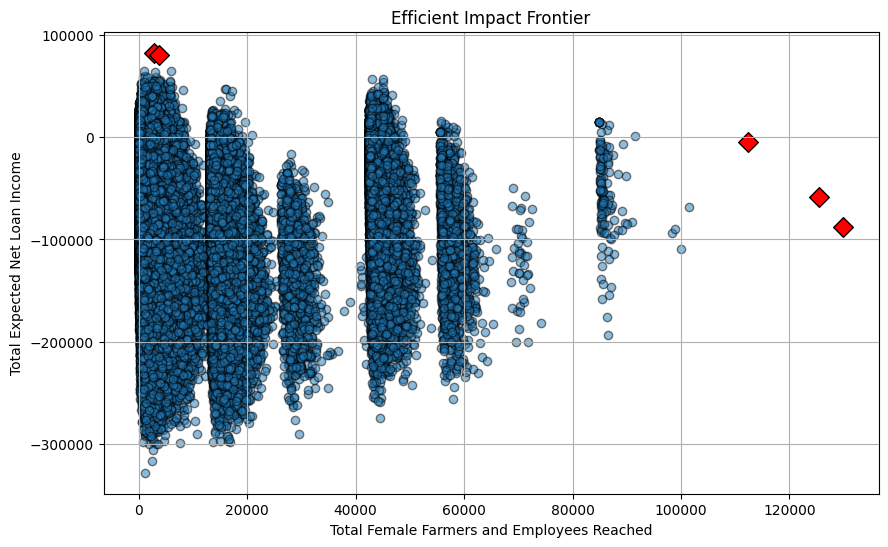

In [59]:

plt.figure(figsize=(10, 6))
plt.scatter(
    portfolio_df_new["Total Female Farmers and Employees Reached"],
    portfolio_df_new["Total Expected Net Loan Income"],
    alpha=0.5,
    edgecolor='k'
)

plt.scatter(
    df_results["Total Female Farmers and Employees Reached"],
    df_results["Total Expected Net Loan Income"],
    c='red',
    edgecolor='k',
    marker='D',
    s=100,
    label="Strategies P1–P5"
)


plt.xlabel("Total Female Farmers and Employees Reached")
plt.ylabel("Total Expected Net Loan Income")
plt.title("Efficient Impact Frontier")
plt.grid(True)
plt.show()

[(937.0, 64837.0), (43025.0, 57293.0), (84962.0, 15268.0), (101559.0, -67905.0)]


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


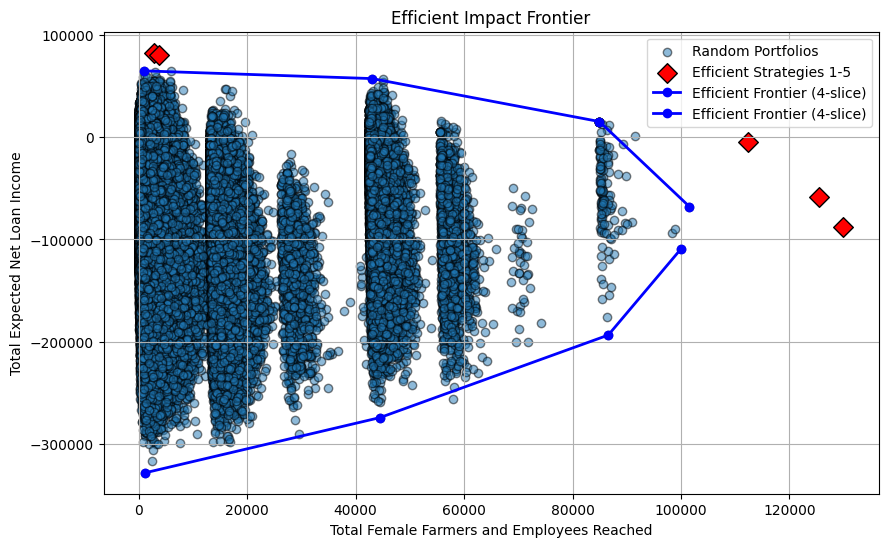

In [61]:
x = portfolio_df_new["Total Female Farmers and Employees Reached"]
y = portfolio_df_new["Total Expected Net Loan Income"]

# 1) Plot all portfolios as a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x, y, alpha=0.5, edgecolor='k', label="Random Portfolios")

# 2) Define bins for slicing the x-axis
bins = [0, 40000, 80000, 95000, 120000]  # 4 slices: [0,40000), [40000,80000), [80000,120000)

max_points = []
# 3) For each slice, find the point that has the maximum y
for i in range(len(bins) - 1):
    low = bins[i]
    high = bins[i+1]
    mask = (x >= low) & (x < high)

    subset = portfolio_df_new[mask]
    if len(subset) > 0:
        # Find the index of the max 'Total Expected Net Loan Income' in this slice
        idx_max = subset["Total Expected Net Loan Income"].idxmax()
        max_points.append((
            subset.loc[idx_max, "Total Female Farmers and Employees Reached"],
            subset.loc[idx_max, "Total Expected Net Loan Income"]
        ))
print(max_points)
min_points = []

# 3.2) For each slice, find the point that has the minimum y
for i in range(len(bins) - 1):
    low = bins[i]
    high = bins[i+1]
    mask = (x >= low) & (x < high)

    subset = portfolio_df_new[mask]
    if len(subset) > 0:
        # Find the index of the min 'Total Expected Net Loan Income' in this slice
        idx_min = subset["Total Expected Net Loan Income"].idxmin()
        min_points.append((
            subset.loc[idx_min, "Total Female Farmers and Employees Reached"],
            subset.loc[idx_min, "Total Expected Net Loan Income"]
        ))



plt.scatter(
    df_results["Total Female Farmers and Employees Reached"],
    df_results["Total Expected Net Loan Income"],
    c='red',
    edgecolor='k',
    marker='D',
    s=100,
    label="Efficient Strategies 1-5"
)

# 4) Plot these 'efficient frontier' points with a line
if max_points:
    frontier_x, frontier_y = zip(*max_points)
    plt.plot(frontier_x, frontier_y, c='blue', marker='o', linewidth=2,
             label="Efficient Frontier (4-slice)")
if min_points:
    frontier_x, frontier_y = zip(*min_points)
    plt.plot(frontier_x, frontier_y, c='blue', marker='o', linewidth=2,
             label="Efficient Frontier (4-slice)")



plt.xlabel("Total Female Farmers and Employees Reached")
plt.ylabel("Total Expected Net Loan Income")
plt.title("Efficient Impact Frontier")
plt.grid(True)
plt.legend()
plt.show()


#Old way of calculating it (crashes on lower number of valid portfolios due to lack of avilable RAM)

In [40]:
target_valid = int(10000)    # number of valid portfolios required
batch_size = 500            # number of candidate portfolios to generate per batch        #CHANGE THESE VALUES TO CORRESPOND TO INSTRUCTIONS
budget = 2500000              # USD 2.5 million budget
n_loans = 200                 # total number of loans


# Lists to store valid portfolios and their allocations
valid_portfolios_list = []
valid_allocations_list = []
collected = 0


# Convert Loan Amount column to a NumPy array
loan_amounts = df["Loan Amount (USD)"].to_numpy()

# total_allocation now uses the array indexing, not the Series indexing


while collected < target_valid:
    candidate_portfolios = []
    candidate_allocations = []

    # Generate a batch of candidate portfolios one-by-one
    for _ in range(batch_size):
        # Randomly choose a number of loans to include (between 1 and 10)
        k = np.random.randint(1, 11)  # k is between 1 and 10 inclusive
        # Randomly select k distinct loan indices from 0 to n_loans-1
        inds = np.random.choice(n_loans, size=k, replace=False)

        # Create a binary vector of length n_loans, with 1s at the selected indices
        candidate = np.zeros(n_loans, dtype=int)
        candidate[inds] = 1

        # Compute the total allocation for this candidate portfolio
        total_allocation = loan_amounts[candidate == 1].sum()
        # If the total allocation is within the budget, save the candidate
        if total_allocation <= budget and total_allocation > 0:
            candidate_portfolios.append(candidate)
            candidate_allocations.append(total_allocation)

    # If any valid candidates were found in this batch, store them
    if candidate_portfolios:
        candidate_portfolios = np.array(candidate_portfolios)
        candidate_allocations = np.array(candidate_allocations)
        valid_portfolios_list.append(candidate_portfolios)
        valid_allocations_list.append(candidate_allocations)
        collected += candidate_portfolios.shape[0]


   # print(_)                    #add to keep track of the progress (supposedly the number of batch already done)

# Concatenate all valid portfolios from the batches
valid_portfolios = np.vstack(valid_portfolios_list)
valid_allocations = np.concatenate(valid_allocations_list)

# Trim the arrays to exactly target_valid portfolios if over-collected
if valid_portfolios.shape[0] > target_valid:
    valid_portfolios = valid_portfolios[:target_valid]
    valid_allocations = valid_allocations[:target_valid]

print("Final valid portfolios shape:", valid_portfolios.shape)

Final valid portfolios shape: (10000, 200)


In [41]:
# Convert the required columns to NumPy arrays (ensuring they are float type)
expected_net_income = df["Expected Net Loan Income"].to_numpy(dtype=float)
female_reached    = df["Female \nFarmers & Employees"].to_numpy(dtype=float)

# Compute totals for each portfolio using dot products
portfolio_net_income    = valid_portfolios.dot(expected_net_income)
portfolio_female_counts = valid_portfolios.dot(female_reached)

# Optionally, convert each binary portfolio (a NumPy array) to a list (for easier storage in the DataFrame)
binary_portfolios = [list(portfolio) for portfolio in valid_portfolios]

# Create the new DataFrame with the binary portfolios and computed metrics
portfolio_df = pd.DataFrame({
    "Portfolio (binary)": binary_portfolios,
    "Total Allocation": valid_allocations,  # from previous sampling
    "Total Expected Net Loan Income": portfolio_net_income,
    "Total Female Farmers and Employees Reached": portfolio_female_counts
})

# Display the first few rows of the new DataFrame
display(portfolio_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Portfolio (binary)                          10000 non-null  object 
 1   Total Allocation                            10000 non-null  int64  
 2   Total Expected Net Loan Income              10000 non-null  float64
 3   Total Female Farmers and Employees Reached  10000 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 312.6+ KB


None

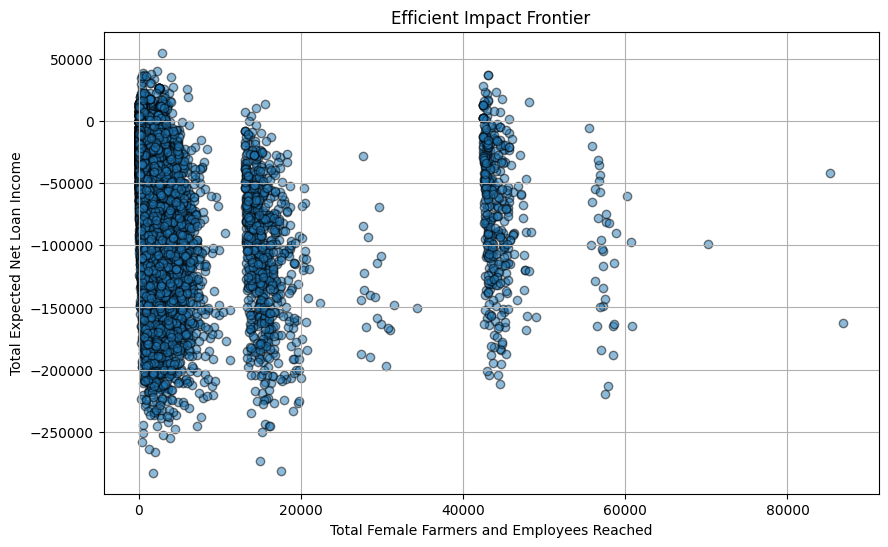

In [42]:

plt.figure(figsize=(10, 6))
plt.scatter(
    portfolio_df["Total Female Farmers and Employees Reached"],
    portfolio_df["Total Expected Net Loan Income"],
    alpha=0.5,
    edgecolor='k'
)
plt.xlabel("Total Female Farmers and Employees Reached")
plt.ylabel("Total Expected Net Loan Income")
plt.title("Efficient Impact Frontier")
plt.grid(True)
plt.show()